In [38]:
import pandas as pd
# Reload the dataset
df = pd.read_csv("/Users/rachanathotireddy/Desktop/Project/Feature_Data_Per_Capita.csv")

# Check for missing values
missing_data = df.isnull().sum()
print(f"Missing data in each column:\n{missing_data}")



Missing data in each column:
state                                 0
annual_median_wage                   50
poverty_rate                        100
opioid_overdose                     101
homelessness_per_capita               0
drug_overdose_deaths_per_capita     100
total_vacant_units_per_capita       150
totalsubsidized_units_per_capita      0
Median_Rent                         100
                                    750
dtype: int64


In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer



# Load dataset
df = pd.read_csv("/Users/rachanathotireddy/Desktop/Project/Feature_Data_Engineered.csv")

# Drop non-predictive columns
df = df.drop(columns=["state", "year"])

# Define target and features
y = df["overall_homeless_per_capita"]
X = df.drop(columns=["overall_homeless_per_capita"])

# Split before imputation to prevent leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Impute only on features (after split)
imputer = IterativeImputer(random_state=42)
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X.columns, index=X_train.index)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X.columns, index=X_test.index)


# Normalize
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imputed), columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_imputed), columns=X.columns, index=X_test.index)

# Summary
print("Feature columns used:")
print(list(X.columns))


Feature columns used:
['number of cocs', 'overall chronically homeless individuals', 'overall homeless veterans', 'overall homeless family households', 'population', 'annual_median_wage', 'hourly_median_wage', 'poverty_rate', 'total_households', 'opioid_overdose', 'total_occupied_housing', 'owner_occupied_housing', 'vacant_for_rent', 'rented_not_occupied', 'vacant_for_sale', 'sold_not_occupied', 'other_vacant_units', 'homelessness_per_capita', 'Median_Rent', 'median_household_income', 'drug_overdose_deaths_per_capita', 'total_vacant_units_per_capita', 'totalsubsidized_units_per_capita', 'Median_Rent_lag1']


/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [41]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Calculate VIF on imputed and scaled training data
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train_scaled.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_scaled.values, i) for i in range(X_train_scaled.shape[1])]

# Sort by highest VIF
vif_data_sorted = vif_data.sort_values("VIF", ascending=False)
vif_data_sorted.head(15)


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Feature,VIF
8,total_households,inf
10,total_occupied_housing,inf
6,hourly_median_wage,9.289097e+05
5,annual_median_wage,9.260221e+05
4,population,6.711588e+02
19,median_household_income,1.428448e+02
11,owner_occupied_housing,8.105826e+01
14,vacant_for_sale,6.704087e+01
16,other_vacant_units,3.817907e+01
12,vacant_for_rent,3.272282e+01


In [44]:
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np

# Initialize Linear Regression (no tuning needed)
lr_model = LinearRegression()

# Define alpha grids for tuning
alphas_ridge = np.logspace(-4, 4, 100)
alphas_lasso = np.logspace(-5, 0, 100)

# Ridge and Lasso with cross-validated alpha
ridge_model = RidgeCV(alphas=alphas_ridge, scoring='neg_mean_squared_error', cv=5)
lasso_model = LassoCV(alphas=alphas_lasso, max_iter=10000, cv=5, random_state=42)

# Train models
lr_model.fit(X_train_scaled, y_train)
ridge_model.fit(X_train_scaled, y_train)
lasso_model.fit(X_train_scaled, y_train)

# Predict
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_ridge = ridge_model.predict(X_test_scaled)
y_pred_lasso = lasso_model.predict(X_test_scaled)

# Evaluation function
def evaluate_model(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    print(f"{name} - RMSE: {rmse:.4f}, R²: {r2:.4f}, MAPE: {mape:.2f}%")

# Evaluate models
print("📊 Evaluation on Test Set (With Hyperparameter Tuning):")
evaluate_model("Linear Regression", y_test, y_pred_lr)
evaluate_model("Ridge Regression (CV)", y_test, y_pred_ridge)
evaluate_model("Lasso Regression (CV)", y_test, y_pred_lasso)

# Show best alphas
print(f"\n✅ Best Ridge Alpha: {ridge_model.alpha_}")
print(f"✅ Best Lasso Alpha: {lasso_model.alpha_}")


📊 Evaluation on Test Set (With Hyperparameter Tuning):
Linear Regression - RMSE: 0.0000, R²: 0.9993, MAPE: 1.96%
Ridge Regression (CV) - RMSE: 0.0000, R²: 0.9993, MAPE: 1.96%
Lasso Regression (CV) - RMSE: 0.0000, R²: 0.9992, MAPE: 1.94%

✅ Best Ridge Alpha: 0.3593813663804629
✅ Best Lasso Alpha: 1e-05


In [10]:
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)

def evaluate_cv_model(name, model, X, y):
    r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
    neg_mse_scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-neg_mse_scores)
    
    # For MAPE
    y_pred = cross_val_predict(model, X, y, cv=kf)
    mape_score = mean_absolute_percentage_error(y, y_pred) * 100

    print(f"{name} - CV R²: {r2_scores.mean():.4f} (± {r2_scores.std():.4f})")
    print(f"{name} - CV RMSE: {rmse_scores.mean():.4f} (± {rmse_scores.std():.4f})")
    print(f"{name} - CV MAPE: {mape_score:.2f}%\n")

# Evaluate all models (fix names here)
print("🔁 5-Fold Cross-Validation Results (Tuned Models):")
evaluate_cv_model("Linear Regression", lr_model, X_train_scaled, y_train)
evaluate_cv_model("Ridge Regression (Tuned)", ridge_model, X_train_scaled, y_train)
evaluate_cv_model("Lasso Regression (Tuned)", lasso_model, X_train_scaled, y_train)


🔁 5-Fold Cross-Validation Results (Tuned Models):
Linear Regression - CV R²: 0.9991 (± 0.0003)
Linear Regression - CV RMSE: 0.0000 (± 0.0000)
Linear Regression - CV MAPE: 2.15%

Ridge Regression (Tuned) - CV R²: 0.9991 (± 0.0003)
Ridge Regression (Tuned) - CV RMSE: 0.0000 (± 0.0000)
Ridge Regression (Tuned) - CV MAPE: 2.17%

Lasso Regression (Tuned) - CV R²: 0.9990 (± 0.0002)
Lasso Regression (Tuned) - CV RMSE: 0.0000 (± 0.0000)
Lasso Regression (Tuned) - CV MAPE: 2.21%



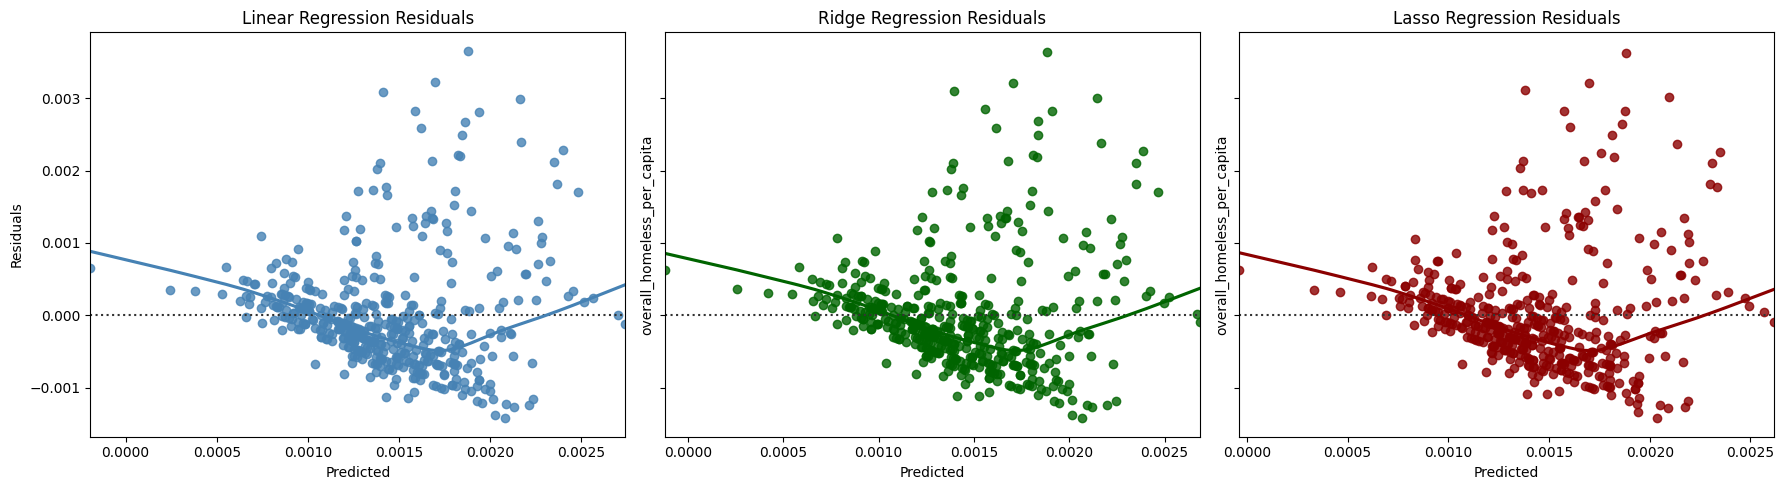

In [272]:
import matplotlib.pyplot as plt
import seaborn as sns

# Generate cross-validated predictions for plotting residuals
from sklearn.model_selection import cross_val_predict

# Get predictions
y_pred_lr_cv = cross_val_predict(lr_model, X_train_scaled, y_train, cv=5)
y_pred_ridge_cv = cross_val_predict(ridge_model, X_train_scaled, y_train, cv=5)
y_pred_lasso_cv = cross_val_predict(lasso_model, X_train_scaled, y_train, cv=5)

# Create residual plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Linear
sns.residplot(x=y_pred_lr_cv, y=y_train - y_pred_lr_cv, ax=axes[0], lowess=True, color='steelblue')
axes[0].set_title("Linear Regression Residuals")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Residuals")

# Ridge
sns.residplot(x=y_pred_ridge_cv, y=y_train - y_pred_ridge_cv, ax=axes[1], lowess=True, color='darkgreen')
axes[1].set_title("Ridge Regression Residuals")
axes[1].set_xlabel("Predicted")

# Lasso
sns.residplot(x=y_pred_lasso_cv, y=y_train - y_pred_lasso_cv, ax=axes[2], lowess=True, color='darkred')
axes[2].set_title("Lasso Regression Residuals")
axes[2].set_xlabel("Predicted")

plt.tight_layout()
plt.show()


In [275]:
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, cross_val_predict
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np

# --- 1. Define parameter grids for all models ---
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 15],
    'weights': ['uniform', 'distance']
}

# --- 2. Initialize models ---
rf = RandomForestRegressor(random_state=42)
xgb = XGBRegressor(random_state=42, objective='reg:squarederror')
knn = KNeighborsRegressor()

# --- 3. Run GridSearchCV for each ---
print("🔄 Running Grid Search for Random Forest...")
rf_grid = GridSearchCV(rf, rf_param_grid, cv=5, scoring='r2', n_jobs=-1)
rf_grid.fit(X_train_scaled, y_train)
best_rf = rf_grid.best_estimator_

print("🔄 Running Grid Search for XGBoost...")
xgb_grid = GridSearchCV(xgb, xgb_param_grid, cv=5, scoring='r2', n_jobs=-1)
xgb_grid.fit(X_train_scaled, y_train)
best_xgb = xgb_grid.best_estimator_

print("🔄 Running Grid Search for KNN...")
knn_grid = GridSearchCV(knn, knn_param_grid, cv=5, scoring='r2', n_jobs=-1)
knn_grid.fit(X_train_scaled, y_train)
best_knn = knn_grid.best_estimator_

# --- 4. Predict on test set ---
y_pred_rf = best_rf.predict(X_test_scaled)
y_pred_xgb = best_xgb.predict(X_test_scaled)
y_pred_knn = best_knn.predict(X_test_scaled)

# --- 5. Evaluation function ---
def evaluate_model(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    print(f"{name} - RMSE: {rmse:.4f}, R²: {r2:.4f}, MAPE: {mape:.2f}%")

# --- 6. Cross-validation function ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)

def model_cv_results(model, X, y, name):
    neg_mse = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=kf)
    r2 = cross_val_score(model, X, y, scoring='r2', cv=kf)
    rmse = np.sqrt(-neg_mse)
    y_pred_cv = cross_val_predict(model, X, y, cv=kf)
    mape = mean_absolute_percentage_error(y, y_pred_cv) * 100

    print(f"\n🔁 {name} - 5-Fold Cross-Validation Results:")
    print(f"R²: {r2.mean():.4f} (± {r2.std():.4f})")
    print(f"RMSE: {rmse.mean():.4f} (± {rmse.std():.4f})")
    print(f"MAPE: {mape:.2f}%")

# --- 7. Test Set Evaluation ---
print("\n📊 Evaluation on Test Set:")
evaluate_model("Random Forest (Tuned)", y_test, y_pred_rf)
evaluate_model("XGBoost (Tuned)", y_test, y_pred_xgb)
evaluate_model("KNN Regression (Tuned)", y_test, y_pred_knn)

# --- 8. Cross-Validation Results ---
model_cv_results(best_rf, X_train_scaled, y_train, "Random Forest (Tuned)")
model_cv_results(best_xgb, X_train_scaled, y_train, "XGBoost (Tuned)")
model_cv_results(best_knn, X_train_scaled, y_train, "KNN Regression (Tuned)")

# --- 9. Print best hyperparameters ---
print("\n✅ Best Hyperparameters:")
print(f"Random Forest: {rf_grid.best_params_}")
print(f"XGBoost: {xgb_grid.best_params_}")
print(f"KNN: {knn_grid.best_params_}")


🔄 Running Grid Search for Random Forest...
🔄 Running Grid Search for XGBoost...
🔄 Running Grid Search for KNN...

📊 Evaluation on Test Set:
Random Forest (Tuned) - RMSE: 0.0008, R²: 0.5454, MAPE: 28.68%
XGBoost (Tuned) - RMSE: 0.0008, R²: 0.4984, MAPE: 32.86%
KNN Regression (Tuned) - RMSE: 0.0006, R²: 0.6938, MAPE: 20.69%

🔁 Random Forest (Tuned) - 5-Fold Cross-Validation Results:
R²: 0.3913 (± 0.1006)
RMSE: 0.0007 (± 0.0001)
MAPE: 30.32%

🔁 XGBoost (Tuned) - 5-Fold Cross-Validation Results:
R²: 0.2891 (± 0.1820)
RMSE: 0.0007 (± 0.0000)
MAPE: 36.00%

🔁 KNN Regression (Tuned) - 5-Fold Cross-Validation Results:
R²: 0.4945 (± 0.1421)
RMSE: 0.0006 (± 0.0001)
MAPE: 23.76%

✅ Best Hyperparameters:
Random Forest: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
XGBoost: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.8}
KNN: {'n_neighbors': 3, 'weights': 'distance'}


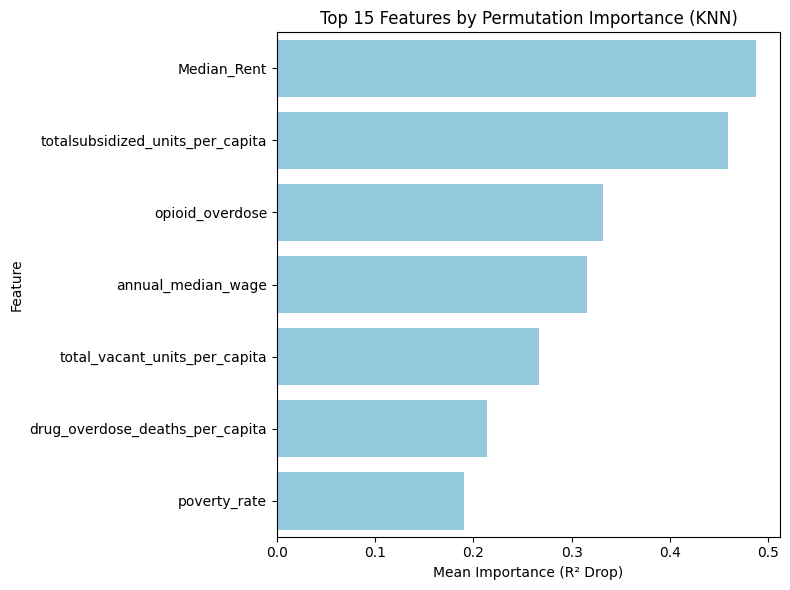

In [292]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance

# Permutation importance for KNN
perm_importance = permutation_importance(knn_grid.best_estimator_, X_test_scaled, y_test, n_repeats=10, random_state=42, scoring='r2')

# Create dataframe
feature_importances = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': perm_importance.importances_mean
}).sort_values(by="Importance", ascending=False).head(15)

# Plot cleanly
plt.figure(figsize=(8, 6))
sns.barplot(data=feature_importances, x="Importance", y="Feature", color="skyblue")
plt.title("Top 15 Features by Permutation Importance (KNN)")
plt.xlabel("Mean Importance (R² Drop)")
plt.ylabel("Feature")
plt.tight_layout()

save_path = "/Users/rachanathotireddy/Desktop/Project/KNN_Feature_Importance.png"

plt.savefig(save_path, dpi=300)
plt.show()

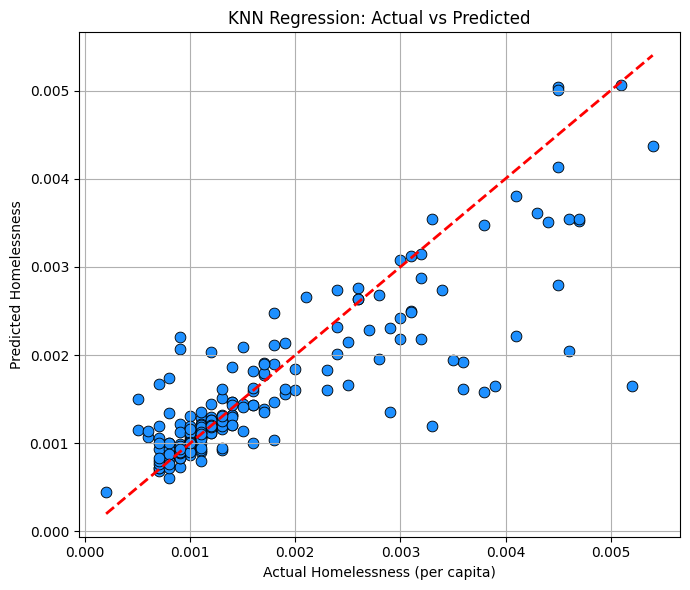

In [282]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure predictions exist
y_pred_knn = knn_grid.predict(X_test_scaled)

# Plot actual vs predicted
plt.figure(figsize=(7, 6))
sns.scatterplot(x=y_test, y=y_pred_knn, color='dodgerblue', s=60, edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel("Actual Homelessness (per capita)")
plt.ylabel("Predicted Homelessness")
plt.title("KNN Regression: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()


In [286]:
import pandas as pd

# Assuming X_train_imputed is the DataFrame before scaling, with feature names
feature_names = X_train_imputed.columns

# Random Forest Feature Importances
rf_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': best_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# XGBoost Feature Importances
xgb_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': best_xgb.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Print Importances
print("\n📋 Random Forest Feature Importances:")
print(rf_importances)
print("\n📋 XGBoost Feature Importances:")
print(xgb_importances)
print("\n📋 KNN Feature Importances: Not available (KNN does not provide feature importances)")


📋 Random Forest Feature Importances:
                            Feature  Importance
0                annual_median_wage    0.193268
3                       Median_Rent    0.182314
5     total_vacant_units_per_capita    0.161142
2                   opioid_overdose    0.152934
6  totalsubsidized_units_per_capita    0.130836
1                      poverty_rate    0.119309
4   drug_overdose_deaths_per_capita    0.060195

📋 XGBoost Feature Importances:
                            Feature  Importance
0                annual_median_wage    0.189430
3                       Median_Rent    0.187100
2                   opioid_overdose    0.151605
1                      poverty_rate    0.136244
4   drug_overdose_deaths_per_capita    0.126561
5     total_vacant_units_per_capita    0.122022
6  totalsubsidized_units_per_capita    0.087038

📋 KNN Feature Importances: Not available (KNN does not provide feature importances)
